## **HOMEWORK 3.2: Food Delivery Route Optimization** <br><br>

**QuickEats** needs to optimize the delivery routes to ensure that the food reaches customers quickly

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import heapq
from typing import Dict, List, Tuple, Set
from collections import defaultdict
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
#First of all, build the weighted graph

class WeightedGraph:
    def __init__(self):
        self.graph = defaultdict(list)
        self.vertices = set()
    
    def add_edge(self, u, v, weight):
        self.graph[u].append((v, weight))
        self.graph[v].append((u, weight))
        self.vertices.add(u)
        self.vertices.add(v)
        
    def get_neighbors(self, u):
        return self.graph[u]
    
    def get_vertices(self):
        return self.vertices
    
    def get_all_edges(self):
        #Get all the edges
        edges = []
        visited = set()

        for v in self.get_vertices():
            for neighbor, weight in self.get_neighbors(v):
                edge = tuple(sorted([v, neighbor]))
                if edge not in visited:
                    edges.append((v, neighbor, weight))
                    visited.add(edge)

        return edges

In [3]:
#Create a delivery network

delivery_network = WeightedGraph()

roads = [
    ('KITCHEN', 'A', 5), ('KITCHEN', 'B', 8), ('KITCHEN', 'C', 12),
    ('A', 'B', 3), ('A', 'D', 7),
    ('B', 'E', 4),
    ('C', 'D', 6), ('C', 'F', 5), ('C', 'G', 8),
    ('D', 'E', 5), ('D', 'F', 3),
    ('E', 'F', 7), ('E', 'H', 4),
    ('F', 'G', 6),
    ('G', 'H', 5)
]

for loc1, loc2, time in roads:
    delivery_network.add_edge(loc1, loc2, time)

print(f"Delivery network created:")
print(f"  Locations: {len(delivery_network.get_vertices())}")
print(f"  Roads: {len(roads)}")
print(f"  Delivery zones: {sorted(delivery_network.get_vertices() - {'KITCHEN'})}")

Delivery network created:
  Locations: 9
  Roads: 15
  Delivery zones: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']


In [4]:
def dijkstra_shortest_path(graph: WeightedGraph, source: str) -> Tuple[Dict[str, float], Dict[str, str]]:
    #1) Initialize all distances to inf
    distances = {v: float('inf') for v in graph.get_vertices()}
    distances[source] = 0
    
    pq = [(0, source)]
    visited = set()

    predecessors = {v: None for v in graph.get_vertices()}

    while pq:
        current_distance, current = heapq.heappop(pq)

        if current in visited:
            continue
        
        visited.add(current)

        for neighbor, time in graph.get_neighbors(current):
            if neighbor in visited:
                continue

            if distances[neighbor] > current_distance + time:
                heapq.heappush(pq, (current_distance + time, neighbor))
                distances[neighbor] = current_distance + time
                predecessors[neighbor] = current

    return distances, predecessors

def reconstruct_path(predecessors: Dict[str, str], source: str, target: str) -> List[str]:
    path = []
    current = target

    while current:
        path.append(current)
        current = predecessors[current]

    path.reverse()

    if path[0] == source:
        return path
    else:
        return []

In [5]:
# Run Dijkstra's algorithm
delivery_times, predecessors = dijkstra_shortest_path(delivery_network, 'KITCHEN')

print("\n✓ Dijkstra's algorithm completed")


✓ Dijkstra's algorithm completed


In [6]:
print("\n" + "="*60)
print("DELIVERY ROUTE ANALYSIS")
print("="*60)

neighborhoods = sorted(delivery_network.get_vertices() - {'KITCHEN'})

print("\nOptimal delivery routes from KITCHEN:\n")

routes_data = []
for neighborhood in neighborhoods:
    route = reconstruct_path(predecessors, 'KITCHEN', neighborhood)
    time = delivery_times[neighborhood]
    routes_data.append((neighborhood, route, time))
    
    print(f"📍 {neighborhood}: {' → '.join(route)} ({time:.0f} min)")

# Statistics
times = [t for _, _, t in routes_data]
avg_time = sum(times) / len(times)
max_time = max(times)
min_time = min(times)

print(f"\n{'='*60}")
print("DELIVERY STATISTICS")
print("="*60)
print(f"Average: {avg_time:.1f} min")
print(f"Fastest: {min_time:.0f} min")
print(f"Slowest: {max_time:.0f} min")

under_15 = len([t for t in times if t <= 15])
print(f"\nUnder 15 min: {under_15}/{len(neighborhoods)} ({under_15/len(neighborhoods)*100:.0f}%)")


DELIVERY ROUTE ANALYSIS

Optimal delivery routes from KITCHEN:

📍 A: KITCHEN → A (5 min)
📍 B: KITCHEN → B (8 min)
📍 C: KITCHEN → C (12 min)
📍 D: KITCHEN → A → D (12 min)
📍 E: KITCHEN → B → E (12 min)
📍 F: KITCHEN → A → D → F (15 min)
📍 G: KITCHEN → C → G (20 min)
📍 H: KITCHEN → B → E → H (16 min)

DELIVERY STATISTICS
Average: 12.5 min
Fastest: 5 min
Slowest: 20 min

Under 15 min: 6/8 (75%)


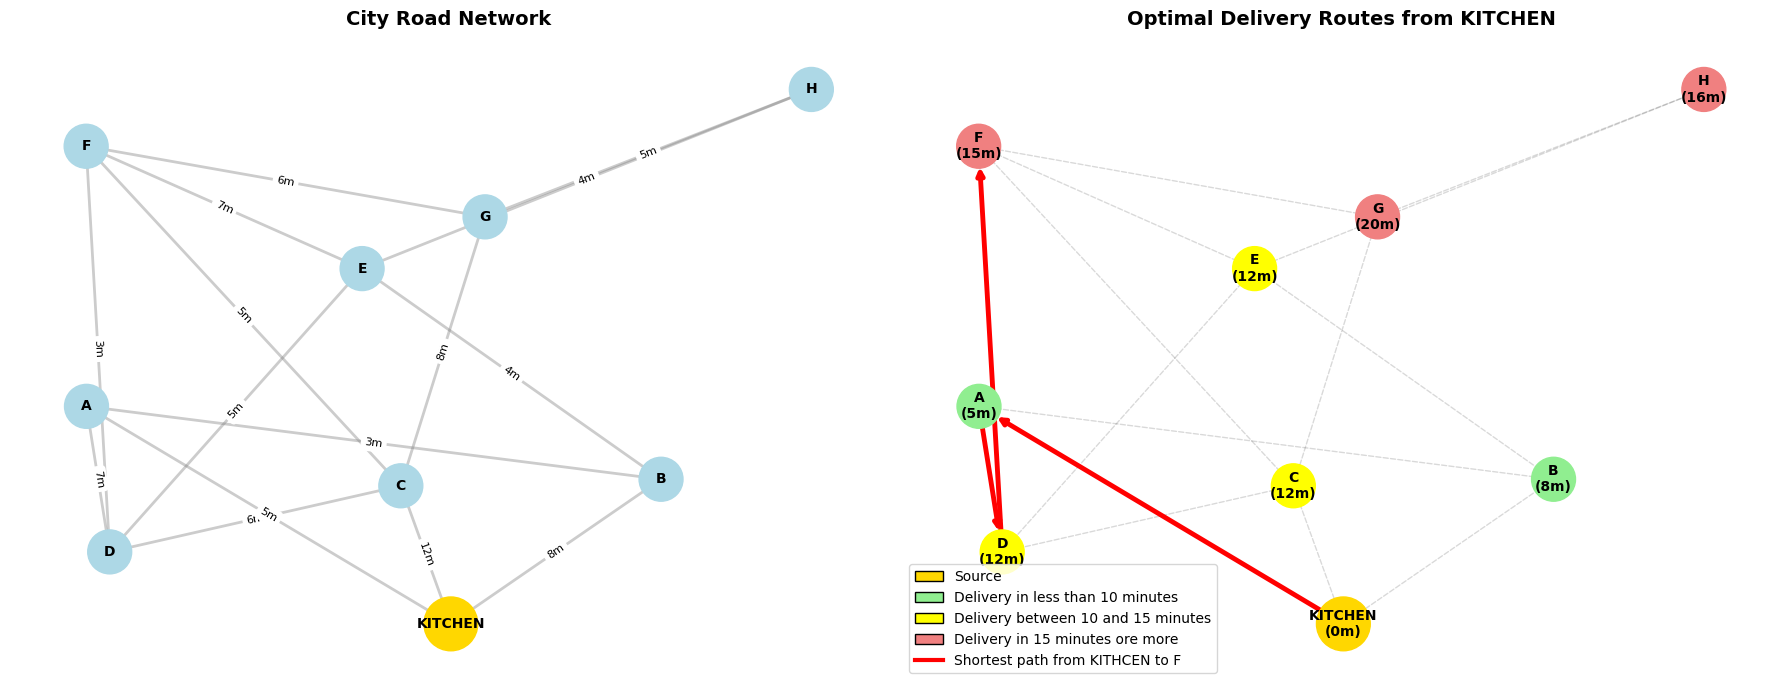

In [7]:
def visualize_delivery_routes(graph: WeightedGraph, source: str, 
                              distances: Dict[str, float], 
                              predecessors: Dict[str, str]):
    """Visualize delivery network and routes."""
    
    # Create NetworkX graph
    G = nx.DiGraph()
    all_edges = graph.get_all_edges()
    for u, v, weight in all_edges:
        G.add_edge(u, v, weight=weight)
    
    pos = nx.spring_layout(G, seed=42, k=2, iterations=50)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Left plot: Road network
    ax1.set_title('City Road Network', fontsize=14, fontweight='bold')
    node_colors = ['gold' if n == source else 'lightblue' for n in G.nodes()]
    node_sizes = [1500 if n == source else 1000 for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax1)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax1)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.4, edge_color='gray', ax=ax1)
    edge_labels = {(u, v): f'{w}m' for u, v, w in all_edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8, ax=ax1)
    ax1.axis('off')

    # TODO: Complete right plot visualization
    ax2.set_title('Optimal Delivery Routes from KITCHEN', fontsize=14, fontweight='bold')
    node_colors = ['gold' if n == source else 'lightgreen' if delivery_times[n] <= 10 else 'yellow' if delivery_times[n] < 15 else 'lightcoral' for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax2 )

    node_labels = {node: f"{node}\n({delivery_times[node]:.0f}m)" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold', ax=ax2)

    
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.15, style='dashed', ax=ax2)
    
    edge_list = reconstruct_path(predecessors, 'KITCHEN', 'F')
    edge_list2 = []
    prev = edge_list[0]
    for edge in edge_list:
        if edge == prev:
            continue

        edge_list2.append((prev, edge))
        prev = edge
    
    nx.draw_networkx_edges(G, pos, edgelist=edge_list2, width=3.5, edge_color='red', arrows= True, alpha=1, min_source_margin=15, min_target_margin=15, ax=ax2)

    node_legend = [
        Patch(facecolor='gold', edgecolor='k', label='Source'),
        Patch(facecolor='lightgreen', edgecolor='k', label='Delivery in less than 10 minutes'),
        Patch(facecolor='yellow', edgecolor='k', label='Delivery between 10 and 15 minutes'),
        Patch(facecolor='lightcoral', edgecolor='k', label='Delivery in 15 minutes ore more'),
    ]

    edge_legend = [Line2D([0], [0], color='red', lw=3, label='Shortest path from KITHCEN to F')]

    ax2.legend(handles=node_legend + edge_legend, loc='lower left', fontsize=10)




    ax2.axis('off')
    plt.tight_layout()
    plt.show()

# Create visualization
visualize_delivery_routes(delivery_network, 'KITCHEN', delivery_times, predecessors)




In [8]:
print("\n" + "="*60)
print("ROUTE COMPARISON: Direct vs Optimal")
print("="*60)

# Find direct connections from KITCHEN
direct_connections = {}
for neighbor, time in delivery_network.graph['KITCHEN']:
    direct_connections[neighbor] = time

print("\nDirect routes from KITCHEN:\n")
for neighborhood in sorted(direct_connections.keys()):
    direct_time = direct_connections[neighborhood]
    optimal_time = delivery_times[neighborhood]
    optimal_route = reconstruct_path(predecessors, 'KITCHEN', neighborhood)
    
    print(f"📍 {neighborhood}:")
    print(f"   Direct: {direct_time} min")
    print(f"   Optimal: {' → '.join(optimal_route)} ({optimal_time:.0f} min)")
    
    if optimal_time < direct_time:
        savings = direct_time - optimal_time
        print(f"   ✓ Saves {savings:.0f} min ({savings/direct_time*100:.0f}%)")
    print()

# Multi-hop routes
indirect = set(delivery_network.get_vertices()) - set(direct_connections.keys()) - {'KITCHEN'}
if indirect:
    print("Multi-hop routes:\n")
    for neighborhood in sorted(indirect):
        route = reconstruct_path(predecessors, 'KITCHEN', neighborhood)
        time = delivery_times[neighborhood]
        hops = len(route) - 1
        print(f"📍 {neighborhood}: {' → '.join(route)} ({time:.0f} min, {hops} hops)")



ROUTE COMPARISON: Direct vs Optimal

Direct routes from KITCHEN:

📍 A:
   Direct: 5 min
   Optimal: KITCHEN → A (5 min)

📍 B:
   Direct: 8 min
   Optimal: KITCHEN → B (8 min)

📍 C:
   Direct: 12 min
   Optimal: KITCHEN → C (12 min)

Multi-hop routes:

📍 D: KITCHEN → A → D (12 min, 2 hops)
📍 E: KITCHEN → B → E (12 min, 2 hops)
📍 F: KITCHEN → A → D → F (15 min, 3 hops)
📍 G: KITCHEN → C → G (20 min, 2 hops)
📍 H: KITCHEN → B → E → H (16 min, 3 hops)
